In [1]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import reptrvae

Using TensorFlow backend.


In [3]:
adata = sc.read('./data/alzPho_count.h5ad')
adata

AnnData object with n_obs × n_vars = 48 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [4]:
adata.obs['Group'].value_counts()

HET    24
WT     24
Name: Group, dtype: int64

In [6]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [252]:
#adata = adata[:, adata.var['highly_variable']]

In [5]:
adata

AnnData object with n_obs × n_vars = 48 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [6]:
adata.X.min(), adata.X.max()

(0.0, 1220000000.0)

In [7]:
adata.obs['Timepoint'].value_counts()

3m    16
6m    16
9m    16
Name: Timepoint, dtype: int64

In [31]:
os.makedirs("./data/", exist_ok=True)

In [11]:
adata.write_h5ad("./data/alzPho_normalized.h5ad")

In [8]:
special_cell_type = "3m"

In [9]:
cell_type_adata = adata[adata.obs["Timepoint"] == special_cell_type]

In [10]:
cell_type_adata.obs['Group'].value_counts()

HET    8
WT     8
Name: Group, dtype: int64

In [11]:
cell_type_adata.obs['Group'].cat.categories

Index(['HET', 'WT'], dtype='object')

In [12]:
sc.tl.rank_genes_groups(cell_type_adata, groups=['HET'], groupby="Group", reference='WT', n_genes=10)

Trying to set attribute `._uns` of view, copying.


/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


In [13]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names']['HET']
top_genes

array(['O08599|STXB1', 'P08226|APOE', 'Q6URW6|MYH14', 'P06800|PTPRC',
       'Q3UGY8|BIG3', 'O88643|PAK1', 'O70439|STX7', 'P61807|SNN',
       'Q7TQH0|ATX2L', 'Q8C5W3|TBCEL'], dtype=object)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


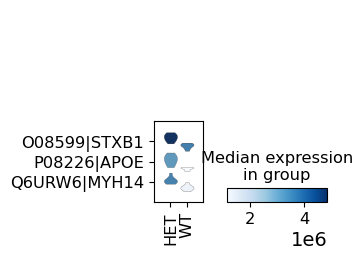

In [14]:
sc.pl.stacked_violin(cell_type_adata, groupby='Group', var_names=top_genes[:3], swap_axes=True)

## Viewing Results

In [15]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [16]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import reptrvae

In [17]:
sc.set_figure_params(dpi=200)

In [52]:
path_to_save = "./results/alzPho/"
sc.settings.figdir = path_to_save

In [53]:
specific_cell_type = "3m"

In [54]:
cell_type_key = "Timepoint"
condition_key = "Group"
target_condition = "HET"
conditions = ['WT', 'HET']

In [55]:
#mode = 'normalized'
mode = 'count'
adata = sc.read(f"./data/alzPho_{mode}.h5ad")
adata

AnnData object with n_obs × n_vars = 48 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [56]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [57]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
cell_type_adata

View of AnnData object with n_obs × n_vars = 16 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint'

In [58]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == 'WT']
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [59]:
ctrl_adata.obs['method'] = 'WT'
real_adata.obs['method'] = target_condition

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [60]:
trvae_reconstructed = sc.read(f"./data/reconstructed/trVAE_alzPho/{specific_cell_type}.h5ad")
trvae_reconstructed

AnnData object with n_obs × n_vars = 16 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'batch'

In [61]:
trvae_reconstructed.X.min(), trvae_reconstructed.X.max()

(0.0, 1140000000.0)

In [62]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"WT_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

In [63]:
models = ctrl_adata.concatenate(real_adata, trvae_pred)
models.obs['method'].unique()

array(['WT', 'HET', 'trVAE'], dtype=object)

In [64]:
models.var_names

Index(['A2A5R2|BIG2', 'A2A690|TANC2', 'A2A699|F1712', 'A2AAE1|K1109',
       'A2AG50|MA7D2', 'A2AHC3|CAMP1', 'A2AIV2|VIR', 'A2AJA9|AJM1',
       'A2AJI0|MA7D1', 'A2AJT4|PNISR',
       ...
       'Q9Z2A0|PDPK1', 'Q9Z2C4|MTMR1', 'Q9Z2C9|MTMR7', 'Q9Z2D6|MECP2',
       'Q9Z2F7|BNI3L', 'Q9Z2H5|E41L1', 'Q9Z2I9|SUCB1', 'Q9Z2M6|UBL3',
       'Q9Z2Q6|SEPT5', 'Q9Z351|KCNQ2'],
      dtype='object', name='Accession', length=1068)

/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Group' as categorical
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'method' as categorical


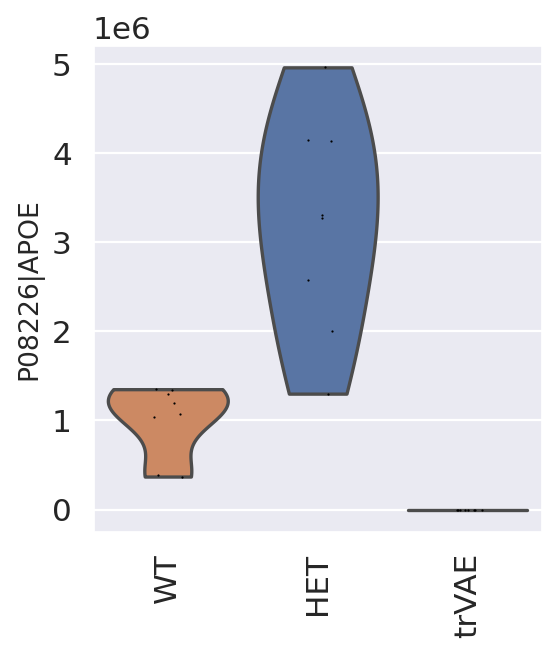

In [65]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="P08226|APOE", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_model_cmpr.pdf",
             jitter=True,
            )
os.rename(src=os.path.join(path_to_save, "violin_model_cmpr.pdf"), 
          dst=os.path.join(path_to_save, "violin_model_comparison.pdf"))

### R^2 Plots

In [66]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
adata_pred

AnnData object with n_obs × n_vars = 24 × 1068
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'method', 'batch'

In [67]:
sc.tl.rank_genes_groups(cell_type_adata, reference='WT', 
                       groupby=condition_key, groups=[target_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition,
                         groupby=condition_key, groups=['WT'],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][target_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names']['WT']

Trying to set attribute `._uns` of view, copying.


/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


In [68]:
top_genes = up_genes.tolist() + down_genes.tolist()

In [69]:
len(top_genes)

100

/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


reg_mean_top100: 0.0
reg_mean_all: 0.0


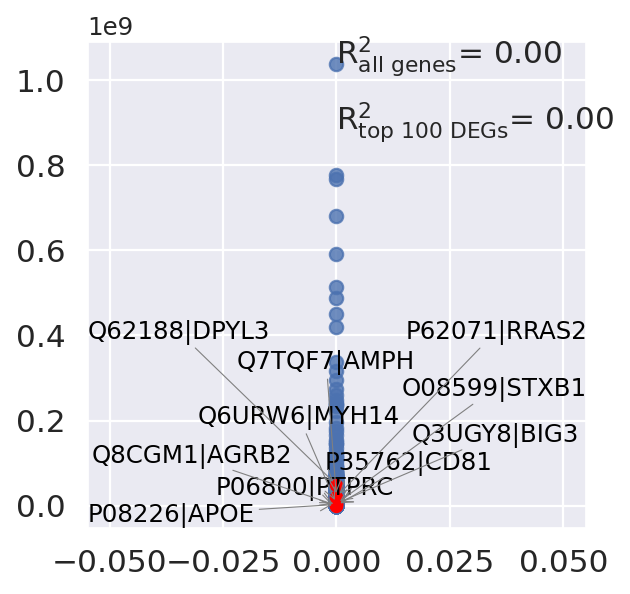

In [70]:
reptrvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/kojo/miniconda3/envs/jowo/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


reg_var_top100: 0.0
reg_var_all: 0.0


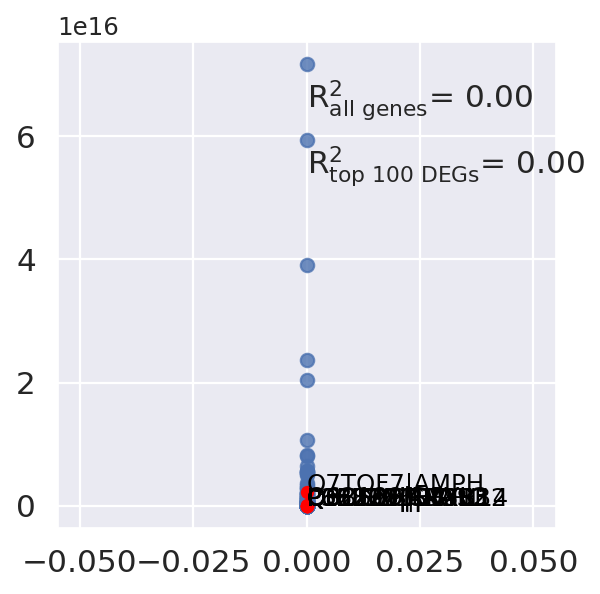

In [71]:
reptrvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"WT_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

In [72]:
up_genes.tolist()

['O08599|STXB1',
 'P08226|APOE',
 'Q6URW6|MYH14',
 'P06800|PTPRC',
 'Q3UGY8|BIG3',
 'O88643|PAK1',
 'O70439|STX7',
 'P61807|SNN',
 'Q7TQH0|ATX2L',
 'Q8C5W3|TBCEL',
 'P98191|CDS1',
 'Q91WL8|WWOX',
 'Q6DFV7|NCOA7',
 'Q8CJ19|MICA3',
 'Q6DIC0|SMCA2',
 'Q68FL4|SAHH3',
 'P23242|CXA1',
 'Q3URD3|SLMAP',
 'Q8BIZ1|ANS1B',
 'Q6P9S0|MTSSL',
 'Q8BY87|UBP47',
 'P21619|LMNB2',
 'P20152|VIME',
 'Q8C419|GP158',
 'P35564|CALX',
 'Q99LG1|TMM51',
 'Q8K019|BCLF1',
 'Q8CFI0|NED4L',
 'Q3V3V9|CARL2',
 'P63213|GBG2',
 'Q5U4C3|SFR19',
 'Q8BPQ7|SGSM1',
 'P63141|KCNA2',
 'A2RSQ0|DEN5B',
 'D3YZU1|SHAN1',
 'A2AN08|UBR4',
 'E9Q4N7|ARI1B',
 'Q91ZU6|DYST',
 'Q80UU9|PGRC2',
 'Q8VCE2|GPN1',
 'Q8C9B9|DIDO1',
 'A2AJT4|PNISR',
 'Q9Z2M6|UBL3',
 'O55131|SEPT7',
 'E9Q5C9|NOLC1',
 'P28663|SNAB',
 'Q9Z2I9|SUCB1',
 'Q9JLQ2|GIT2',
 'Q91WK0|LRRF2',
 'P35831|PTN12']

In [73]:
down_genes.tolist()

['Q7TQF7|AMPH',
 'P62071|RRAS2',
 'Q8CGM1|AGRB2',
 'P35762|CD81',
 'Q62188|DPYL3',
 'Q9Z2Q6|SEPT5',
 'P13808|B3A2',
 'P63168|DYL1',
 'Q9CR16|PPID',
 'P62874|GBB1',
 'P06745|G6PI',
 'P20917|MAG',
 'P04370|MBP',
 'P68510|1433F',
 'Q68FD5|CLH1',
 'Q8BR92|PALM2',
 'Q61097|KSR1',
 'A2AJI0|MA7D1',
 'Q923T9|KCC2G',
 'P39688|FYN',
 'Q99P72|RTN4',
 'Q8BR63|F177A',
 'P63101|1433Z',
 'Q99JT2|STK26',
 'Q5XJV6|LMTK3',
 'Q03141|MARK3',
 'P60904|DNJC5',
 'P27659|RL3',
 'Q9CW07|PP13G',
 'Q9JKC6|CEND',
 'Q8R4U7|LUZP1',
 'Q60780|GAS7',
 'Q9QYE3|BC11A',
 'Q4U2R1|HERC2',
 'Q68FM6|PPR29',
 'Q91W96|APC4',
 'Q5RJI5|BRSK1',
 'Q60771|CLD11',
 'O70622|RTN2',
 'Q3UHL1|CAMKV',
 'Q5XG69|F169A',
 'Q80TL0|PPM1E',
 'Q58A65|JIP4',
 'P84075|HPCA',
 'Q69ZW3|EHBP1',
 'Q8CHG7|RPGF2',
 'A2AHC3|CAMP1',
 'Q9D0M5|DYL2',
 'P18572|BASI',
 'P17751|TPIS']